In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import preproccessing as prep
from evaluation import show_scenarios_evaluation
from regime_switching_brownian_motion import RegimeSwitching
from independent_lognormal_model import IndependentLogNormal
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
def convert_to_transition_matrix(p00,p10):
     k =2
     transition_matrix = np.zeros((k,k))
     transition_matrix[0,0] = p00
     transition_matrix[1,0] = p10
     transition_matrix[:,1] = 1 - transition_matrix[:,0]
     return transition_matrix


In [3]:
world = pd.read_excel('msci_world_usd_30.10.23.xlsx',index_col='Date', parse_dates=True)
world = world.squeeze()
world_returns = prep.log_returns(world)
world_returns.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 645 entries, 1970-01-30 to 2023-09-29
Series name: WORLD Standard (Large+Mid Cap)
Non-Null Count  Dtype  
--------------  -----  
645 non-null    float64
dtypes: float64(1)
memory usage: 10.1 KB


In [4]:
periods = [
    ('1970-11-01', '2023-10-30'),
    ('1973-11-01', '2023-10-30'),
    ('1973-11-01', '2019-12-31'),
    ('1983-11-01', '2023-10-30'),
    ('1993-11-01', '2023-10-30'),
    ('1994-01-01', '2023-10-30'),
    ('1999-01-01', '2023-10-30'),
    ('2003-11-01', '2023-10-30'),    
    ('2013-11-01', '2023-10-30'),
]

prep.asset_stats(world_returns,periods)

,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
"(1970-11-01, 2023-10-30)",0.086692,0.149740,-0.741006,2.083054,1.311509,-0.540291
"(1973-11-01, 2023-10-30)",0.083414,0.152316,-0.734475,1.982212,1.214788,-0.540291
"(1973-11-01, 2019-12-31)",0.084773,0.148525,-0.775601,2.290275,1.277495,-0.540291
"(1983-11-01, 2023-10-30)",0.087665,0.153639,-0.821811,2.135338,1.300174,-0.540291
"(1993-11-01, 2023-10-30)",0.069209,0.153336,-0.846681,1.913494,0.885784,-0.540291
"(1994-01-01, 2023-10-30)",0.069964,0.153121,-0.853065,1.959404,0.904120,-0.540291
"(1999-01-01, 2023-10-30)",0.054665,0.157324,-0.775767,1.730128,0.543091,-0.540291
"(2003-11-01, 2023-10-30)",0.073676,0.155547,-0.923110,2.514783,0.972673,-0.540291
"(2013-11-01, 2023-10-30)",0.076207,0.147438,-0.532838,1.085640,1.085649,-0.254242


my chosen params
mu1 = 1.35
mu2 = -0.11
sig1 = 0.07
sig2 = 0.33
p00 = 92.38
p20 = 8.74

In [92]:
data = world_returns
n_regimes = 2
params = []

for period in periods:
    model = sm.tsa.MarkovRegression(
    data[period[0]:period[1]],
    k_regimes=n_regimes,
    switching_variance=True,
    freq=None
    )
    result = model.fit()
    for k in range(n_regimes):
        result.params[f'sigma2[{k}]'] = np.sqrt(result.params[f'sigma2[{k}]'])
    
    params.append(np.round(result.params * 100,2))

params = pd.DataFrame(data=params, index=periods)
params

c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\si

,p[0->0],p[1->0],const[0],const[1],sigma2[0],sigma2[1]
"(1970-11-01, 2023-10-30)",92.89,9.55,1.36,-0.13,2.63,5.75
"(1973-11-01, 2023-10-30)",92.36,8.90,1.37,-0.11,2.60,5.75
"(1973-11-01, 2019-12-31)",93.15,8.74,1.35,-0.13,2.59,5.67
"(1983-11-01, 2023-10-30)",91.88,8.38,1.44,-0.00,2.46,5.71
"(1993-11-01, 2023-10-30)",94.20,5.34,1.35,-0.18,2.37,5.66
"(1994-01-01, 2023-10-30)",94.50,5.50,1.34,-0.20,2.40,5.70
"(1999-01-01, 2023-10-30)",94.75,4.42,1.35,-0.31,2.33,5.68
"(2003-11-01, 2023-10-30)",94.66,6.41,1.30,-0.21,2.29,6.05
"(2013-11-01, 2023-10-30)",72.29,9.99,1.76,0.24,0.81,4.85


interactive(children=(FloatSlider(value=2.5500000000000003, description='mu1', max=5.0, min=0.1, step=0.01), F…

<function __main__.show_RSLN_scenarios_evaluation(mu1, mu2, sigma1, sigma2, p00, p10, initial_values, current_regime, dt, n_scenarios, n_steps, hist)>

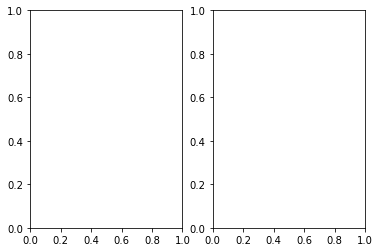

In [247]:
t_m = convert_to_transition_matrix(0.924,0.087)
initial_values=100
current_regime=0
dt=1
n_scenarios=2000
n_steps= 300
hist=world_returns

def show_RSLN_scenarios_evaluation(mu1, mu2, sigma1, sigma2, p00,p10, initial_values, current_regime, dt, n_scenarios, n_steps, hist):
      
    transition_matrix = convert_to_transition_matrix(p00/100,p10/100)

    model = RegimeSwitching(
    models=[IndependentLogNormal(mu=mu1/100,sigma=sigma1/100),
            IndependentLogNormal(mu=mu2/100,sigma=sigma2/100)],
    probs=transition_matrix
    )

    scenarios = model.scenarios(initial_values,current_regime,dt,n_steps, n_scenarios)
    scenarios = pd.DataFrame(data=scenarios, index=range(n_scenarios), columns=range(n_steps+1))

    show_scenarios_evaluation(scenarios,hist)



interact_manual(show_RSLN_scenarios_evaluation,         
         mu1=(0.1,5,0.01),
         mu2=(-3,3,0.01),
         sigma1=(1,7, 0.1),
         sigma2=(1,7, 0.1),
         p00 = (80,99,0.1),
         p10 = (1,20,0.1),
         initial_values=100,
         current_regime=0,
         dt=1,
         n_scenarios=2000,
         n_steps= 300,
         hist=fixed(world_returns)
         )



In [16]:
usdpln = prep.loadStooqData('usdpln','1998-12-01','d')
usdpln = usdpln.resample('M').last()
usdpln_ret = prep.log_returns(usdpln)
world_pln = (world * usdpln).dropna()
world_pln_returns = prep.log_returns(world_pln)
prep.assets_performance(world_pln_returns['2000-01-01':])

Annualised Mean     0.068650
Annualised Sigma    0.156900
Skew               -0.504753
Kurtosis            0.998444
Sharp_ratio         0.853329
Max drowdawn       -0.498474
dtype: float64

In [24]:
df = pd.DataFrame(data=[world_returns['1999-01-01':],usdpln_ret]).T
df['WORLD Standard (Large+Mid Cap)'].fillna(method='ffill', inplace=True)
df.dropna(axis=0, inplace=True)

In [39]:
print(df['Zamkniecie'].corr(df['WORLD Standard (Large+Mid Cap)']))
print(df['Zamkniecie'].std()*np.sqrt(12))

-0.5715473853891408
0.13016767514553187


In [52]:
print('Pln original regime params')
n_regimes =2
model = sm.tsa.MarkovRegression(
    world_pln_returns['1999-01-01':],
    k_regimes=n_regimes,
    switching_variance=True,
    freq=None
    )
result = model.fit()
for k in range(n_regimes):
    result.params[f'sigma2[{k}]'] = np.sqrt(result.params[f'sigma2[{k}]']) 
result.params

Original regime params


c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


p[0->0]      0.934645
p[1->0]      0.089467
const[0]     0.015634
const[1]    -0.004344
sigma2[0]    0.031173
sigma2[1]    0.059894
dtype: float64

In [53]:
print('usd params')
n_regimes =2
model = sm.tsa.MarkovRegression(
    df['WORLD Standard (Large+Mid Cap)'],
    k_regimes=n_regimes,
    switching_variance=True,
    freq=None
    )
result = model.fit()
for k in range(n_regimes):
    result.params[f'sigma2[{k}]'] = np.sqrt(result.params[f'sigma2[{k}]']) 
result.params

usd params


c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


p[0->0]      0.948296
p[1->0]      0.040980
const[0]     0.013564
const[1]    -0.003695
sigma2[0]    0.023114
sigma2[1]    0.056310
dtype: float64

In [48]:
df['Regimes'] = result.smoothed_marginal_probabilities.idxmax(axis=1)
print('Regime 0 std, corr with world')
usdpln_reg0_std = df[df['Regimes']==0]['Zamkniecie'].std()
print(usdpln_reg0_std * np.sqrt(12))
usdpln_reg0_corr = df[df['Regimes']==0]['Zamkniecie'].corr(df[df['Regimes']==0]['WORLD Standard (Large+Mid Cap)'])
print(usdpln_reg0_corr)
print('Regime 1 std, corr with world')
print(df[df['Regimes']==1]['Zamkniecie'].std()*np.sqrt(12))
print(df[df['Regimes']==1]['Zamkniecie'].corr(df[df['Regimes']==1]['WORLD Standard (Large+Mid Cap)']))

Regime 0 std, corr with world
0.10504744964643539
-0.4863868084471058
Regime 1 std, corr with world
0.148298067208312
-0.6178065026612005


In [50]:
print('World pln calculate regime0 std')
prep.foreign_asset_std(0.023114,usdpln_reg0_std,usdpln_reg0_corr)

World pln calculate regime0 std


0.02778486351697094

In [42]:
asset_std = df['WORLD Standard (Large+Mid Cap)'].std()
usdpln_std = df['Zamkniecie'].std()
corr = df['Zamkniecie'].corr(df['WORLD Standard (Large+Mid Cap)'])
world_pln_returns_calc = prep.foreign_asset_std(asset_std,usdpln_std,corr)

In [99]:
import gbm_gibbs as gibs
sampler = gibs.GibsSamplerGBM(world_returns['2003-01-01':'2023-07-31'],0.0064)
sampler.run()
mu = sampler.mu_dist
sig = sampler.sigma_dist
print(pd.Series(mu*12, name='mu').describe())
print(pd.Series(sig * np.sqrt(12), name='sigma').describe())


count    10001.000000
mean         0.084799
std          0.001215
min          0.000000
25%          0.084690
50%          0.084816
75%          0.084945
max          0.085589
Name: mu, dtype: float64
count    10001.000000
mean         0.218088
std          0.005741
min          0.000000
25%          0.214752
50%          0.217879
75%          0.221268
max          0.240232
Name: sigma, dtype: float64


In [100]:
sampler = gibs.GibsSamplerGBM(world_returns['1970-01-01':'2023-07-31'],0.0064)
sampler.run()
mu = sampler.mu_dist
sig = sampler.sigma_dist
print(pd.Series(mu*12, name='mu').describe())
print(pd.Series(sig * np.sqrt(12), name='sigma').describe())

count    10001.000000
mean         0.084969
std          0.001204
min          0.000000
25%          0.084941
50%          0.084987
75%          0.085033
max          0.085269
Name: mu, dtype: float64
count    10001.000000
mean         0.212261
std          0.004116
min          0.000000
25%          0.210283
50%          0.212197
75%          0.214261
max          0.223748
Name: sigma, dtype: float64


In [75]:
from typing import Any
from scipy.stats import norm

class XPdf:
    
    def __init__(self, mu, sigma) -> None:
        self.mu = mu
        self.sigma = sigma

    def __call__(self, x):
        return norm.pdf((x-self.mu)/self.sigma)
    

xpdf = XPdf(0.08,0.15)
xpdf(0.15)


0.357783429167969

In [111]:
p00 = 0.95
p10 = 0.08
mu1 = 0.1
mu2 = -0.015
sigma1 = 0.08
sigma2 = 0.19
transition_matrix = convert_to_transition_matrix(p00,p10)
xpdf1 = XPdf(mu1, sigma1)
xpdf2 = XPdf(mu2, sigma2)

def initial_state(xpdf1, xpdf2, t_m, x):
    """
    t_m : transition matrix 
    """
    pi1 = t_m[1,0]/(t_m[0,1]+t_m[1,0])
    pi2 = t_m[0,1]/(t_m[0,1]+t_m[1,0])

    f1 = (pi1*t_m[0,0] + pi2*t_m[1,0]) * xpdf1(x)
    f2 = (pi1*t_m[0,1] + pi2*t_m[1,1]) * xpdf2(x)
    fy = f1 + f2

    #probability state 1 given parameters
    pp1 = f1/fy
    pp2 = f2/fy

    return pi1, pi2, f1, f2, fy, pp1, pp2

initial_state(xpdf1,xpdf2,transition_matrix, 0.09)

x = [0.09, 0.13, -0.03]


""" 
px = prob x given pt1, pt-1 1 and 2 + pt2, pt-1 1 and 2
py = f(pt1=1,pt-1=1)+f(pt1=1,pt-1=2)+f(pt1=2,pt-1=1)+f(pt1=2,pt-1=2)
"""


(0.6153846153846151,
 0.3846153846153848,
 0.24359242273523035,
 0.131710254689736,
 0.37530267742496637,
 0.6490559150991705,
 0.3509440849008294)

In [113]:
def sample_states(mus,sigmas,t_m, x):

  params = np.concatenate([np.array(t_m).T[:-1].flatten(), mus,sigmas, ])
  k_regimes = len(t_m)
  T = len(x)
  states = np.zeros(T)
  regimes = range(k_regimes)

  model = sm.tsa.MarkovRegression(
    x,
    k_regimes=k_regimes,
    switching_variance=True,
    )
  probs = model.smooth(params).smoothed_marginal_probabilities

  for t in range(T):
    states[t] = np.random.choice(regimes,p=probs[t],size=1)
  return states

In [115]:
mus= [0.01, 0.05]
sigmas = [0.007, 0.055]

t_m = [[0.93, 0.07], [0.06, 0.94]]
t_m3 = [[0.92, 0.06, 0.02],
        [0.05, 0.92, 0.03],
        [0.05, 0.1, 0.985]]

x = [0.02,0.01,0.08,-0.11, 0.29, 0.03]

res = []
for i in range(1000):
  res.append(sample_states(mus, sigmas, t_m,x))

np.sum(res,0)


array([216., 267., 360., 552., 853., 719.])

In [186]:
from scipy import stats

class TransitionMatrixSampler:
  
  def __init__(self, states, u0) -> None:
    self.states = states
    self.u0 = u0

  def calculate_states(self):
    k_regimes = np.unique(self.states).max()+1
    m = np.zeros((k_regimes, k_regimes))
    for t in range(len(self.states)-1):
      m[self.states[t], self.states[t+1]] +=1

    return m
  
  def distribution_params(self):
    transition_count = self.calculate_states()
    params = np.zeros((3,3,2))
    indices = np.arange(3)
    #return np.add([[transition_count[0,0], transition_count[0,1]],[transition_count[1,1],transition_count[1,0]]], self.u0)

    for m in range(3):
      mask = indices != m
      pii = transition_count[m,m]
      pij = transition_count[m,mask].sum()
      params[m,m] = [pii,pij]
      
    return params
  
  def sample(self):
    params = self.distribution_params()
    transition_matrix = np.zeros_like(params)
    k_regimes = len(transition_matrix)
    last = [1,0]

    for k in range(k_regimes):
      transition_matrix[k,k] = stats.beta(params[k,0],params[k,1]).rvs(1)
      transition_matrix[k,last[k]] = 1 - transition_matrix[k].sum()

    return transition_matrix
  
states3 = [1,0,0,0,1,1,0,1,2,0,2,2,1]
states2 = [1,0,0,0,1,1,0,1,0,1]
u02 = [[0.98,0.02],[0.02,0.98]]
u03 = [[0.98,0.02, 0.02],[0.02,0.98, 0.02],[0.02,0.02,0.98] ]

sampler = TransitionMatrixSampler(states3, u03)
count = sampler.calculate_states()
print(count)
print(sampler.distribution_params())

#sampler.sample()


[[2. 2. 1.]
 [2. 1. 1.]
 [1. 1. 1.]]
[[[2. 3.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [1. 3.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [1. 2.]]]


[[[2,3],[2,1]],
 [[1,3],[2,1],
 [[1,2],[1,2]]]

[[[0,[1,2],[1,2]],
 [[1,[0,2]],[0,2]]
]

In [171]:
arr = np.array([[2, 2, 1,],
                [2, 1, 1,],
                [1, 1, 1,]])

indices = [0,1,2]

mask = np.array(indices) != 2
arr[0][mask]

array([2, 2])

In [187]:
ind = [1,2,3,4]
c = [1,3,4]

np.equal(ind,c)

ValueError: operands could not be broadcast together with shapes (4,) (3,) 

In [191]:
import numpy as np

# Let's assume you have a square matrix 'A'
A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

print(A)
# For lower triangular matrix, get row starting from index zero
lower_triangular = np.tril(A)
print(lower_triangular)
for i in range(lower_triangular.shape[0]):
    print("Row", i, ":", lower_triangular[i])

# For upper triangular matrix, get row starting from last index
upper_triangular = np.triu(A)
print(upper_triangular)
for i in range(upper_triangular.shape[0]-1, -1, -1):
    print("Row", i, ":", upper_triangular[i])


[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[1 0 0]
 [4 5 0]
 [7 8 9]]
Row 0 : [1 0 0]
Row 1 : [4 5 0]
Row 2 : [7 8 9]
[[1 2 3]
 [0 5 6]
 [0 0 9]]
Row 2 : [0 0 9]
Row 1 : [0 5 6]
Row 0 : [1 2 3]


In [210]:
x = np.arange(9)
x = np.reshape(x,(3,3))
print(x)
shift = 3 - 1
np.roll(x,shift,axis=1)

[[0 1 2]
 [3 4 5]
 [6 7 8]]


array([[1, 2, 0],
       [4, 5, 3],
       [7, 8, 6]])

In [212]:
arr = np.array([1,2,np.nan,4])


dtype('float64')

In [220]:
np.arange(16).reshape((4,4))

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [219]:
np.eye(4) @ np.arange(16).reshape((4,4))


array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.],
       [12., 13., 14., 15.]])

In [245]:
def sample_states(mus,sigmas,t_m, x):

  params = np.concatenate([np.array(t_m).T[:-1].flatten(), mus,sigmas, ])
  k_regimes = len(t_m)
  T = len(x)
  states = np.zeros(T,dtype=np.int32)
  regimes = range(k_regimes)

  model = sm.tsa.MarkovRegression(
    x,
    k_regimes=k_regimes,
    switching_variance=True,
    )
  probs = model.smooth(params).smoothed_marginal_probabilities
  
  for t in range(T):
    states[t] = np.random.choice(regimes,p=probs[t],size=1) 
  
  return states

mus= [0.01, 0.05]
sigmas = [0.007, 0.055]

t_m = [[0.93, 0.07], [0.06, 0.94]]
t_m3 = [[0.92, 0.06, 0.02],
        [0.05, 0.92, 0.03],
        [0.05, 0.1, 0.985]]

#x = [0.02,0.01,0.08,-0.11, 0.29, 0.03]
x = world_returns.to_numpy()

res = []
for i in range(1000):
  res.append(sample_states(mus, sigmas, t_m,x))

np.sum(res,0)


array([ 56,  18,   9,  16,  12,   8,   5,   7,   1,   4,   6,   6,   5,
         3,   3,   2,   2,   2,   2,   3,   5,   4,   6,  10,   6,   5,
         5,   3,   8,   3,   2,   6,   6,   7,   3,   6,   4,   2,   5,
         4,   5,   6,   3,   5,   3,   7,  13,   7,   6,   4,   4,   4,
         7,   6,  13,  18,  13,   4,  11,   4,  14,  11,   8,   7,   4,
         7,  10,   2,   7,   6,   4,   3,   5,   4,   1,   3,   5,   4,
         5,   7,   4,   3,   7,   4,   5,   3,   1,   3,   6,   3,   4,
         6,   4,   5,   5,   4,   1,   4,   6,   5,   9,   5,  10,   5,
         5,   4,   6,   7,   4,   1,   2,   2,   1,   5,   3,   4,   7,
         6,   8,  10,   3,   6,   9,  13,   6,   7,   4,   2,   6,   4,
         4,   2,   4,   0,   1,   1,   5,   5,   5,   9,   9,   5,   6,
         7,   4,   2,   5,   5,   9,   8,   5,   5,   3,   1,   7,   3,
         5,   5,   7,   8,   4,   7,   2,   5,   4,   3,   3,   3,   6,
         2,   5,   2,   8,   3,  10,   5,   9,   8,   3,   3,   

In [228]:
from scipy.stats import beta

class TransitionMatrixSampler:

  def __init__(self, states, u0) -> None:
    self.states = states
    self.u0 = u0
    self.k_regimes = np.unique(self.states).max()+1
    self.transition_count = self.calculate_states_transitions()
    self.alfas = np.full((self.k_regimes, self.k_regimes),np.nan)
    self.betas = np.full((self.k_regimes, self.k_regimes), np.nan)

    self.calculate_distribution_params()

  def calculate_states_transitions(self):

    m = np.zeros((self.k_regimes, self.k_regimes))
    for t in range(len(self.states)-1):
      m[self.states[t], self.states[t+1]] +=1

    return m

  def calculate_distribution_params(self):
    params = np.zeros((self.k_regimes,self.k_regimes,2))
    indices = np.arange(self.k_regimes, dtype=np.int32)

    for i in indices:      
      row = np.roll(indices,-i)
      ui = np.roll(self.u0[i],-i)
      for j in indices[:-1]:        
        self.alfas[i,row[j]] = np.add(self.transition_count[i,row[j]],ui[j])
        mask = np.all([indices != i,indices != row[j]],axis=0) 
        self.betas[i,row[j]] = self.transition_count[i,mask].sum()   
             
   

  def sample(self):

    t_m = np.full((self.k_regimes,self.k_regimes),np.nan)

    for i in range(self.k_regimes):      
      alfas = np.roll(self.alfas[i],-i)
      betas = np.roll(self.betas[i],-i)
      for j in range(self.k_regimes-1):
        t_m[i,j] = np.random.beta(alfas[j],betas[j],1)
      t_m[i,-1] = 1 - np.nansum(t_m[i])           
      t_m[i] = np.roll(t_m[i],i)
        
    return t_m

states3 = [1,0,0,0,1,1,0,1,2,0,2,2,1]
states2 = [1,0,0,0,1,1,0,1,0,1]
states4 = [1,0,0,3,0,1,1,0,3,3,1,3,2,0,2,2,1,2,2,3,3,3,0,1,2,1,2,1,2,3,2,3,2,3,3,1,0,0,0,0,0,0,0]
u02 = [[0.98,0.02],[0.02,0.98]]
u03 = [[0.98,0.02, 0.02],[0.02,0.98, 0.02],[0.02,0.02,0.98]]
u04 = np.array([[0.96,0.02, 0.02, 0.02],[0.02,0.96, 0.02, 0.02],[0.02,0.02, 0.96, 0.02,], [0.02,0.02, 0.02,0.96,]])

sampler = TransitionMatrixSampler(states4, u04)

print(sampler.transition_count)
print('alfas:')
print(sampler.alfas)
print('betas')
print(sampler.betas)

sample = sampler.sample()
sample


[[7. 2. 1. 2.]
 [3. 1. 4. 1.]
 [1. 3. 2. 4.]
 [2. 2. 3. 4.]]
alfas:
[[7.96 2.02 1.02  nan]
 [ nan 1.96 4.02 1.02]
 [1.02  nan 2.96 4.02]
 [2.02 2.02  nan 4.96]]
betas
[[ 5.  3.  4. nan]
 [nan  8.  4.  7.]
 [ 7. nan  8.  4.]
 [ 5.  5. nan  7.]]


array([[ 0.70171782,  0.126174  ,  0.28588876, -0.11378058],
       [ 0.1113546 ,  0.32453156,  0.5259704 ,  0.03814343],
       [ 0.10825269, -0.06206487,  0.31179617,  0.64201601],
       [ 0.16805664,  0.11603581,  0.49616074,  0.21974681]])

In [241]:
def rs_gibs_sampler(x, mus0, sigmas0, t_m0, u0, n_samples):

  xn = []
  if(isinstance(x,pd.DataFrame)):
    xn = x.to_numpy()
  
  t_m = np.zeros((n_samples,t_m0.shape[0],t_m0.shape[0]))

  for n in range(n_samples):
    states = sample_states(mus0,sigmas0,t_m0,xn)
    t_m[n] = TransitionMatrixSampler(states,u0).sample()

  return t_m



mus= [0.01, 0.05]
sigmas = [0.007, 0.055]

t_m = np.array([[0.93, 0.07], [0.06, 0.94]])
u0 = [[0.98, 0.02], [0.02, 0.98] ]

t_m3 = [[0.92, 0.06, 0.02],
        [0.05, 0.92, 0.03],
        [0.05, 0.1, 0.985]]

x = world_returns #[0.02,0.01,0.08,-0.11, 0.29, 0.03]


t_m = rs_gibs_sampler(x, mus, sigmas, t_m, u0,1000)


ValueError: zero-size array to reduction operation maximum which has no identity